In [0]:
import urllib.request
import shutil
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from patsy import dmatrices,dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load Data

In [0]:
# read or get file
file_name='mccase.txt'

try: 
    file = open(file_name,'r')
except:
    url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
    # Download the file from `url` and save it locally under `file_name`:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()

# PYrs is the fraction of compelete policy years 
# there are some policies with 0.0 duration (1/365 = 0.00274 = 1 day)
# set these to 1 day
df.loc[df['PYrs']==0.0,'PYrs'] = 1.0/365.0

# single claim frequency indicator
df['Claim'] = (df['Claims']>=1).astype(int)

# avg severity
df['SeverityAvg'] = (df['Severity'] / df['Claims']).fillna(0.0)

pd.DataFrame({'dtype':df.dtypes,'null':df.isnull().sum(),'nunique':df.nunique()})

,dtype,null,nunique
Age,float64,0,85
Sex,category,0,2
Geog,category,0,7
EV,category,0,7
VehAge,int64,0,85
NCD,category,0,7
PYrs,float64,0,2577
Claims,int64,0,3
Severity,float64,0,590
Claim,int64,0,2


# Prep Data

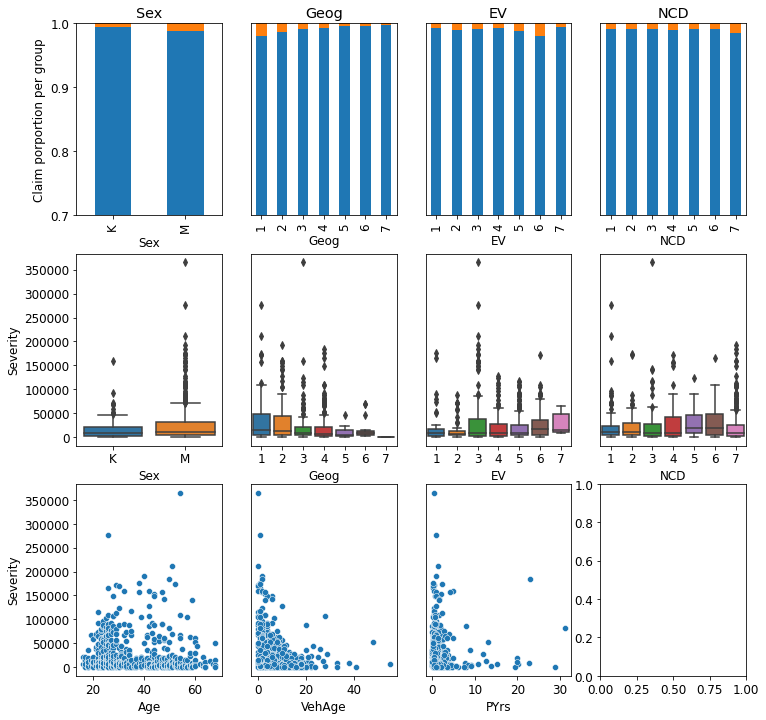

In [0]:
claims = df.loc[df['Claims']!=0]

fig,axs=plt.subplots(3,4,figsize=(12,12),sharey=False)

# claim proportions by category
for ax,feat in zip(axs.flatten()[:4],df.select_dtypes(include='category').columns):
    ((pd.crosstab(df['Claim'],df[feat])) /
                    (pd.crosstab(df['Claim'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
    ax.set_ylim(0.7,1)
    ax.set_yticks([])
axs[0,0].set_yticks(np.arange(0.7,1.0,0.1))
axs[0,0].set_ylabel('Claim porportion per group')

# severity by category
for col,ax in zip(df.select_dtypes(include='category').columns,axs.flatten()[4:]):
    sns.boxplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

# severity by continuous
for col,ax in zip(['Age','VehAge','PYrs'],axs.flatten()[8:]):
    sns.scatterplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

for ax in axs[1:3,0]:
    ax.set_ylabel('Severity')
    ax.set_yticks(np.arange(0,4e5,5e4))

# Model

## prep train-test data

In [0]:
# train-test splits stratifies on claims
# take copies to overcome chained assignment
train,test = train_test_split(df,test_size=0.3,random_state=1990,stratify=df['Claim'])
train = df.loc[train.index].copy()
test = df.loc[test.index].copy()
a,b,c,d = train['Claim'].sum(),train['Severity'].sum(),test['Claim'].sum(),test['Severity'].sum()
print(f"Frequency\nTrain:\t{len(train)}\t{a}\t${b}\nTest:\t{len(test)}\t{c}\t${d}\n")

# severity train test
train_severity = train.loc[train['Claim']>0].copy()
test_severity = test.loc[test['Claim']>0].copy()
a,b,c,d = train_severity['Claim'].sum(),train_severity['Severity'].sum(),test_severity['Claim'].sum(),test_severity['Severity'].sum()
print(f"Severity\nTrain:\t{len(train_severity)}\t{a}\t${b}\nTest:\t{len(test_severity)}\t{c}\t${d}\n")

Frequency
Train:	45183	469	$11664342.0
Test:	19365	201	$5377478.0

Severity
Train:	469	469	$11664342.0
Test:	201	201	$5377478.0



## GLM-frequency

In [0]:
# # examples of formula notation in smf
# print(' + '.join(train.columns))
# expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

# including PYrs as parameter commented out in glm()
expr = "Claims ~ Age + Sex + Geog + EV + VehAge + NCD" # + np.log(PYrs)

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

# uses the binary "Claim" field as target
# offset is Pyrs (Years complete 0.0...n)
# aka similar to binary logistic regression
FreqBinom = smf.glm(formula="Claim ~ Age + Sex + Geog + EV + VehAge + NCD " ,
                    data=train,
                    freq_weights=train['PYrs'],
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()



## GLM-severity

Dispersion: 2.0528
Shape: 0.4872
Intercept: 69330.81


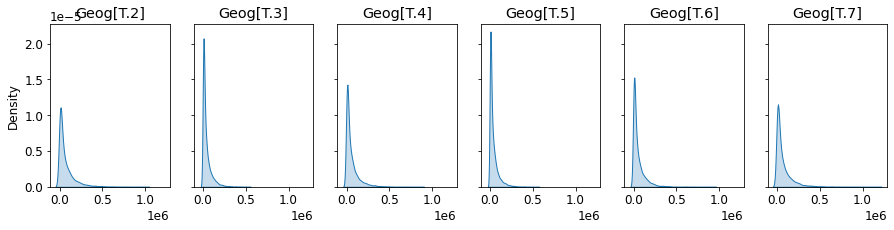

In [0]:
# formula
expr = "SeverityAvg ~ Age + Sex + Geog + EV + VehAge + NCD"

### Estimate severity using GLM-gamma with default log link
SevGamma = smf.glm(formula=expr,
                   data=train_severity,
                   family=sm.families.Gamma(link=sm.families.links.log())).fit()

# dispersion aka rate
dispersion = SevGamma.scale
print(f'Dispersion: {dispersion:.4f}')

# shape is 1/dispersion
shape = 1/dispersion
print(f'Shape: {shape:.4f}')

# intercept
constant,intercept = SevGamma.params[0],np.exp(SevGamma.params[0])
print(f'Intercept: {intercept:.2f}')

# predicted mean G(Yi) is exp(Bo + Bi*Xi..)
# tuple(name,Yi,scale)
geogs = [(i,
          np.exp(constant+c),
          np.exp(constant+c)*dispersion)
         for i,c in zip(SevGamma.params.index,SevGamma.params) if 'Geog' in i]

# plot
fig,axs = plt.subplots(1,6,sharex=True,sharey=True,figsize=(15,3))

for ax,x in zip(axs.flatten(),geogs):
    sns.kdeplot(np.random.gamma(shape=shape,scale=x[2],size=10000),shade=True,ax=ax,)
    ax.set_title(x[0])

# Predict Per Policy

In [0]:
sample = test.sample(10)

In [0]:
alpha = 0.01 

for n in range(1000):
    # sample binomial P from modelled conf-interval
    binom_ci = FreqBinom.get_prediction(sample).summary_frame(alpha=alpha)
    binom_ci = np.random.normal(loc=binom_ci['mean'],scale=binom_ci['mean_se'])
    binom_ci[binom_ci < 0] = 0
    binom_pred = np.random.binomial(n=1,p=binom_ci)

    # sample poisson Y from modelled conf-interval
    poiss_ci = FreqPoisson.get_prediction(sample).summary_frame(alpha=alpha)
    poiss_ci = np.random.normal(loc=poiss_ci['mean'],scale=poiss_ci['mean_se'])
    poiss_ci[poiss_ci < 0] = 0
    poiss_pred = np.random.poisson(lam=poiss_ci)


    # gamma coefs and params
    gamma_dummy = smf.glm(formula=expr,data=sample,family=sm.families.Gamma(link=sm.families.links.log()))
    gamma_coef = pd.DataFrame(gamma_dummy.data.exog * SevGamma.params.values,columns=gamma_dummy.data.param_names)
    dispersion = SevGamma.scale
    shape = 1/dispersion
    gamma_scale = np.exp(gamma_coef.sum(axis=1).values)*dispersion
    gamma_pred = np.random.gamma(shape=shape,scale=gamma_scale)

    
    result_ = (binom_pred*poiss_pred)*gamma_pred
    

Out[110]: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])